<a href="https://colab.research.google.com/github/ehtisham409/code-champ/blob/master/Simple_PDE_using_DGM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
     %tensorflow_version 1.x

In [ ]:
# CLASS DEFINITIONS FOR NEURAL NETWORKS USED IN DEEP GALERKIN METHOD

#%% import needed packages
import tensorflow as tf

#%% LSTM-like layer used in DGM (see Figure 5.3 and set of equations on p. 45) - modification of Keras layer class

class LSTMLayer(tf.keras.layers.Layer):

    # constructor/initializer function (automatically called when new instance of class is created)
    def __init__(self, output_dim, input_dim, trans1 = "tanh", trans2 = "tanh"):
        '''
        Args:
            input_dim (int):       dimensionality of input data
            output_dim (int):      number of outputs for LSTM layers
            trans1, trans2 (str):  activation functions used inside the layer;
                                   one of: "tanh" (default), "relu" or "sigmoid"

        Returns: customized Keras layer object used as intermediate layers in DGM
        '''

        # create an instance of a Layer object (call initialize function of superclass of LSTMLayer)
        super(LSTMLayer, self).__init__()

        # add properties for layer including activation functions used inside the layer
        self.output_dim = output_dim
        self.input_dim = input_dim

        if trans1 == "tanh":
            self.trans1 = tf.nn.tanh
        elif trans1 == "relu":
            self.trans1 = tf.nn.relu
        elif trans1 == "sigmoid":
            self.trans1 = tf.nn.sigmoid

        if trans2 == "tanh":
            self.trans2 = tf.nn.tanh
        elif trans2 == "relu":
            self.trans2 = tf.nn.relu
        elif trans2 == "sigmoid":
            self.trans2 = tf.nn.relu

        ### define LSTM layer parameters (use Xavier initialization)
        # u vectors (weighting vectors for inputs original inputs x)
        self.Uz = self.add_variable("Uz", shape=[self.input_dim, self.output_dim],
                                    initializer = tf.contrib.layers.xavier_initializer())
        self.Ug = self.add_variable("Ug", shape=[self.input_dim ,self.output_dim],
                                    initializer = tf.contrib.layers.xavier_initializer())
        self.Ur = self.add_variable("Ur", shape=[self.input_dim, self.output_dim],
                                    initializer = tf.contrib.layers.xavier_initializer())
        self.Uh = self.add_variable("Uh", shape=[self.input_dim, self.output_dim],
                                    initializer = tf.contrib.layers.xavier_initializer())

        # w vectors (weighting vectors for output of previous layer)
        self.Wz = self.add_variable("Wz", shape=[self.output_dim, self.output_dim],
                                    initializer = tf.contrib.layers.xavier_initializer())
        self.Wg = self.add_variable("Wg", shape=[self.output_dim, self.output_dim],
                                    initializer = tf.contrib.layers.xavier_initializer())
        self.Wr = self.add_variable("Wr", shape=[self.output_dim, self.output_dim],
                                    initializer = tf.contrib.layers.xavier_initializer())
        self.Wh = self.add_variable("Wh", shape=[self.output_dim, self.output_dim],
                                    initializer = tf.contrib.layers.xavier_initializer())

        # bias vectors
        self.bz = self.add_variable("bz", shape=[1, self.output_dim])
        self.bg = self.add_variable("bg", shape=[1, self.output_dim])
        self.br = self.add_variable("br", shape=[1, self.output_dim])
        self.bh = self.add_variable("bh", shape=[1, self.output_dim])


    # main function to be called
    def call(self, S, X):
        '''Compute output of a LSTMLayer for a given inputs S,X .
        Args:
            S: output of previous layer
            X: data input

        Returns: customized Keras layer object used as intermediate layers in DGM
        '''

        # compute components of LSTM layer output (note H uses a separate activation function)
        Z = self.trans1(tf.add(tf.add(tf.matmul(X,self.Uz), tf.matmul(S,self.Wz)), self.bz))
        G = self.trans1(tf.add(tf.add(tf.matmul(X,self.Ug), tf.matmul(S, self.Wg)), self.bg))
        R = self.trans1(tf.add(tf.add(tf.matmul(X,self.Ur), tf.matmul(S, self.Wr)), self.br))

        H = self.trans2(tf.add(tf.add(tf.matmul(X,self.Uh), tf.matmul(tf.multiply(S, R), self.Wh)), self.bh))

        # compute LSTM layer output
        S_new = tf.add(tf.multiply(tf.subtract(tf.ones_like(G), G), H), tf.multiply(Z,S))

        return S_new

#%% Fully connected (dense) layer - modification of Keras layer class

class DenseLayer(tf.keras.layers.Layer):

    # constructor/initializer function (automatically called when new instance of class is created)
    def __init__(self, output_dim, input_dim, transformation=None):
        '''
        Args:
            input_dim:       dimensionality of input data
            output_dim:      number of outputs for dense layer
            transformation:  activation function used inside the layer; using
                             None is equivalent to the identity map

        Returns: customized Keras (fully connected) layer object
        '''

        # create an instance of a Layer object (call initialize function of superclass of DenseLayer)
        super(DenseLayer,self).__init__()
        self.output_dim = output_dim
        self.input_dim = input_dim

        ### define dense layer parameters (use Xavier initialization)
        # w vectors (weighting vectors for output of previous layer)
        self.W = self.add_variable("W", shape=[self.input_dim, self.output_dim],
                                   initializer = tf.contrib.layers.xavier_initializer())

        # bias vectors
        self.b = self.add_variable("b", shape=[1, self.output_dim])

        if transformation:
            if transformation == "tanh":
                self.transformation = tf.tanh
            elif transformation == "relu":
                self.transformation = tf.nn.relu
        else:
            self.transformation = transformation


    # main function to be called
    def call(self,X):
        '''Compute output of a dense layer for a given input X
        Args:
            X: input to layer
        '''

        # compute dense layer output
        S = tf.add(tf.matmul(X, self.W), self.b)

        if self.transformation:
            S = self.transformation(S)

        return S

#%% Neural network architecture used in DGM - modification of Keras Model class

class DGMNet(tf.keras.Model):

    # constructor/initializer function (automatically called when new instance of class is created)
    def __init__(self, layer_width, n_layers, input_dim, final_trans=None):

        # create an instance of a Model object (call initialize function of superclass of DGMNet)
        super(DGMNet,self).__init__()

        # define initial layer as fully connected
        # NOTE: to account for time inputs we use input_dim+1 as the input dimensionality
        self.initial_layer = DenseLayer(layer_width, input_dim, transformation = "tanh")

        # define intermediate LSTM layers
        self.n_layers = n_layers
        self.LSTMLayerList = []

        for _ in range(self.n_layers):
            self.LSTMLayerList.append(LSTMLayer(layer_width, input_dim))

        # define final layer as fully connected with a single output (function value)
        self.final_layer = DenseLayer(1, layer_width, transformation = final_trans)


    # main function to be called
    def call(self,x):
        '''
        Args:
            t: sampled time inputs
            x: sampled space inputs
        Run the DGM model and obtain fitted function value at the inputs (t,x)
        '''

        # define input vector as time-space pairs
        X = tf.concat([x],1)

        # call initial layer
        S = self.initial_layer.call(X)

        # call intermediate LSTM layers
        for i in range(self.n_layers):
            S = self.LSTMLayerList[i].call(S,X)

        # call final LSTM layers
        result = self.final_layer.call(S)

        return result

In [ ]:
# SCRIPT FOR SOLVING THE FOKKER-PLANCK EQUATION FOR ORNSTEIN-UHLENBECK PROCESS
# WITH RANDOM (NORMALLY DISTRIBUTED) STARTING VALUE (see p.54)

#%% import needed packages


import tensorflow as tf
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

#%% Parameters


# bounds of sampling region for space dimension, i.e. sampling will be done on
# [multiplier*Xlow, multiplier*Xhigh]
Xlow = 0.0
Xhigh = 2.0
x_multiplier = 2.0
alpha = 1.5

# neural network parameters
num_layers = 3
nodes_per_layer = 50
learning_rate = 0.001

# Training parameters
sampling_stages = 100   #(number of EPOCHS) number of times to resample new time-space domain points
steps_per_sample = 10   # number of SGD steps to take before re-sampling

# Sampling parameters

nSim_x_interior = 50
nSim_x_initial = 50


#%% Sampling function - randomly sample time-space pairs



In [ ]:
def sampler( nSim_x_interior, nSim_x_initial):

    # Sampler #1: domain interior
    x_interior = np.random.uniform(low=Xlow, high=Xhigh, size=[nSim_x_interior, 1])

    # Sampler #2: spatial boundary
        # no spatial boundary condition for this problem

    # Sampler #3: initial/terminal condition
    x_initial = np.random.uniform(low=Xlow, high=Xhigh, size = [nSim_x_initial, 1])

    return x_interior, x_initial

#%% Loss function for Fokker-Planck equation



In [ ]:
def loss(model, x_interior, x_initial):



        # compute function value and derivatives at current sampled points
        u    = model(x_interior)
        u_x  = tf.gradients(u, x_interior)[0]

        diff_f = u_x + 1/5*u - tf.exp(-x_interior/5)*tf.cos(x_interior)
    # average losses across sample time points
        L1 = tf.reduce_mean(tf.square(diff_f))

        fitted_pdf = model(0*tf.ones_like(x_initial))


    # average L2 error for initial distribution
        L3 = tf.reduce_mean(tf.square(fitted_pdf))

        return L1, L3

#%% Set up network

# initialize DGM model (last input: space dimension = 1)


In [ ]:
model = DGMNet(nodes_per_layer, num_layers, 1)

# tensor placeholders (_tnsr suffix indicates tensors)
# inputs (time, space domain interior, space domain at initial time)
x_interior_tnsr = tf.placeholder(tf.float32, [None,1])
x_initial_tnsr = tf.placeholder(tf.float32, [None,1])

# loss
L1_tnsr, L3_tnsr = loss(model,  x_interior_tnsr, x_initial_tnsr)
loss_tnsr = L1_tnsr + L3_tnsr

V = model(x_interior_tnsr)

# set optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss_tnsr)

# initialize variables
init_op = tf.global_variables_initializer()

# open session
sess = tf.Session()
sess.run(init_op)

#%% Train network
# for each sampling stage
for i in range(sampling_stages):

    # sample uniformly from the required regions
    x_interior, x_initial = sampler(nSim_x_interior, nSim_x_initial)

    # for a given sample, take the required number of SGD steps
    for j in range(steps_per_sample):
        loss,L1,L3,_ = sess.run([loss_tnsr, L1_tnsr, L3_tnsr, optimizer],
                                feed_dict = {x_interior_tnsr:x_interior, x_initial_tnsr:x_initial})

    #print(loss, L1, L3, i)
    if (i + 1) % 10 == 0:

       print("Epoch {:4d} has loss {:6.8f} where L1 is {:9f} L3 is {:9f}".format(i,loss,L1,L3))

Epoch    9 has loss 0.00002772 where L1 is  0.000026 L3 is  0.000002
Epoch   19 has loss 0.00001520 where L1 is  0.000015 L3 is  0.000000
Epoch   29 has loss 0.00000959 where L1 is  0.000010 L3 is  0.000000
Epoch   39 has loss 0.00000637 where L1 is  0.000006 L3 is  0.000000
Epoch   49 has loss 0.00000471 where L1 is  0.000005 L3 is  0.000000
Epoch   59 has loss 0.00000525 where L1 is  0.000005 L3 is  0.000000
Epoch   69 has loss 0.00000240 where L1 is  0.000002 L3 is  0.000000
Epoch   79 has loss 0.00000252 where L1 is  0.000003 L3 is  0.000000
Epoch   89 has loss 0.00000142 where L1 is  0.000001 L3 is  0.000000
Epoch   99 has loss 0.00000103 where L1 is  0.000001 L3 is  0.000000


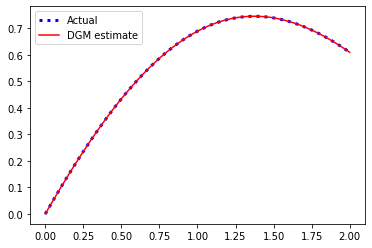

In [ ]:
n_plot = 100
x_plot = np.linspace(Xlow, Xhigh, n_plot)

# compute normalized density at all x values to plot and current t value
fitted_Value = sess.run([V], feed_dict= { x_interior_tnsr:x_plot.reshape(-1,1)})

# plot histogram of simulated process values and overlay estimated density
plt.plot(x_plot, np.exp(-x_plot/5)*np.sin(x_plot), color = 'b', label='Actual', linewidth = 3, linestyle=':')
plt.plot(x_plot, fitted_Value[0], color = 'r', label='DGM estimate')
plt.legend(loc='upper left', prop={'size': 10})

In [ ]:
fitted_Value[0].shape

(100, 1)

In [ ]:
x_interior = np.random.uniform(low=Xlow, high=Xhigh, size=[nSim_x_interior, 1])

In [ ]:
x_interior.shape

(50, 1)